<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task5(Lite)_RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lite**

#Классификация заболеваний по базе симптомов.

**1. Импорт библиотек.**

In [ ]:
from google.colab import files
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Загрузка базы текстов.**

In [ ]:
!rm -R '/content/texts' #remove texts directory
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Болезни.zip' -d '/content/texts' #unzip to created `texts` directory

In [ ]:
def readtext(file_name): #read all text in 1 raw
  file=open(file_name, 'r')
  text=file.read()
  text=text.replace("\n"," ")
  return text

In [ ]:
diseases = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", "Холицестит", "Эзофагит", "Энтерит", "Язва"] #list of unique diseases
diseases_qty=len(diseases)
diseases_qty

10

In [ ]:
train_text=[]

for i in diseases:
  for t in os.listdir('/content/texts/Болезни'):
    if i in t:
      train_text.append(readtext('/content/texts/Болезни/'+t))

print(len(train_text))
print(len(train_text[0]))

10
4075


In [ ]:
train_text[0]

'Резкая боль в животе Повышение температуры Напряженность мышц Тошнота  Острая боль в животе, в том числе и при надавливании Повышение температуры Тошнота Рвота  Тупая боль возле пупка или верхней части живота, которая становится острой, опускаясь в нижнюю правую часть живота. Обычно это первый симптом; Потеря аппетита; Тошнота и/или рвота вскоре после того, как началась боль в животе; Отек брюшной полости; Повышение температуры.  Тупя или острая боль в верхней или нижней части живота, спины или прямой кишки; Болезненное и/или затрудненное мочеиспускание; Рвота Сильные судороги Запор или диарея  Боль в животе, сначала в эпигастральной области или околопупочной области; нередко она имеет нелокализованный характер (боли «по всему животу») Отсутствие аппетита  Тошнота рвота 1-2 кратная  Подъём температуры до 37-38 жидкий стул частые мочеиспускания повышение числа сердечных сокращений повышение давления  Потеря аппетита тошнота Рвота Повышение температуры тела Запор или диарея  Боль в живо

**3. Нормирование и преобразование данных.**

In [ ]:
max_words_qty=2000
toks=Tokenizer(num_words=max_words_qty, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=" ",
                 oov_token='unknown', char_level=False) #create tokenizer model based on words frequency
toks.fit_on_texts(train_text) #apply tokens to train texts
freq_items=list(toks.word_index.items()) #extracting words with their indexes
print(len(freq_items))
freq_items[:10]

1981


[('unknown', 1),
 ('в', 2),
 ('и', 3),
 ('боль', 4),
 ('тошнота', 5),
 ('или', 6),
 ('рвота', 7),
 ('боли', 8),
 ('живота', 9),
 ('при', 10)]

In [ ]:
#print("Word's index is ", toks.word_index[input("Enter the word: ")])

In [ ]:
train_word_indexes=toks.texts_to_sequences(train_text) #convert train texts into indexes
print(train_text[2][:100])
print(train_word_indexes[2][:12])

Желтуха начало гепатита напоминает грипп: повышение температуры тела головная боль общее недомогание
[132, 998, 999, 1000, 1001, 25, 26, 19, 95, 4, 133, 150]


**4. Статистика по данным.**

In [ ]:
symbols_train_text=0
words_train_text=0
print("Train texts statistic:")
print()
for i in range(diseases_qty):
  print(diseases[i]," "*(10-len(diseases[i])), len(train_text[i]), "symbols, ", len(train_word_indexes[i]), "words")
  symbols_train_text+=len(train_text[i]) #sum overall qty of symbols within all authors train texts
  words_train_text+=len(train_word_indexes[i]) #sum overall qty of words within all authors test texts                  

print('-------')
print("Overall symbols: ", symbols_train_text, " Overall words: ", words_train_text,) 

Train texts statistic:

Аппендицит  4075 symbols,  579 words
Гастрит     6717 symbols,  839 words
Гепатит     5523 symbols,  687 words
Дуоденит    3941 symbols,  488 words
Колит       9127 symbols,  1192 words
Панкреатит  11313 symbols,  1480 words
Холицестит  6157 symbols,  841 words
Эзофагит    5867 symbols,  793 words
Энтерит     6383 symbols,  828 words
Язва        3460 symbols,  472 words
-------
Overall symbols:  62563  Overall words:  8199


**5. Создание обучающей и проверочной выборки.**

In [ ]:
def getSetIndexes(wordIndexes, xLen, step): #cut separate author's text into xLen samples
  x_sample=[]
  wordslen=len(wordIndexes)
  index=0
  while (index+xLen)<=wordslen:
    x_sample.append(wordIndexes[index:index+xLen])
    index+=step
  return x_sample

In [ ]:
def getAllSetsIndexes(wordIndexes, xLen, step): #create X set cut into defined length of samples and Y set with correspond author within all authors
  classes=len(wordIndexes) #10 diseases
  class_x_sample=[]
  for w in wordIndexes: #take each list of indexes of 10 lists
    class_x_sample.append(getSetIndexes(w, xLen, step)) #cut each text list into samples and append to summary list of lists

  X_sam=[]
  Y_sam=[]
  for c in range(classes): #within 10 diseases
    cx=class_x_sample[c] #all cut samples of each disease's list
    for x in range(len(cx)): #within qty of all samples of each disease
      X_sam.append(cx[x]) #append all cut samples to final list
      Y_sam.append(utils.to_categorical(c, classes)) #append all correspond disease's vectors to final list

  X_sam=np.array(X_sam)
  Y_sam=np.array(Y_sam)
  return (X_sam, Y_sam)

In [ ]:
xLen=50
step=5
x, y=getAllSetsIndexes(train_word_indexes, xLen, step)
print(x.shape)
print(y.shape)

(1545, 50)
(1545, 10)


In [ ]:
x_train, x_val, y_train, y_val=train_test_split(x, y, test_size=0.2, shuffle=True)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1236, 50)
(1236, 10)
(309, 50)
(309, 10)


**6. Распознавание проверочной выборки по категориям**

In [ ]:
def recognizeMultiClass (model, xTest, yTest):
  total_sum=0
  for i in range(diseases_qty):
    correct=0
    dis=0
    for v in range(x_val.shape[0]):
      pred=model.predict(xTest[v].reshape(1,50))
      max_pred=np.argmax(pred, axis=1)
      if max_pred==i and max_pred==np.argmax(yTest[v]):
        correct+=1
      if np.argmax(yTest[v])==i:
        dis+=1
    print("For", diseases[i], "recognized: ", round((correct/dis)*100,1), "%")
    total_sum+=correct
    if i==diseases_qty-1:
      print('--------------------')
      print("Overall recognized: ", round((total_sum/x_val.shape[0])*100,1), "%")


**7. Создание и обучение 3 разных сетей.**

**- Embedding + LSTM**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 25)            50000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 25)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 50)            15200     
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25010     
Total params: 90,210
Trainable params: 90,210
Non-trainable params: 0
_________________________________________________________________



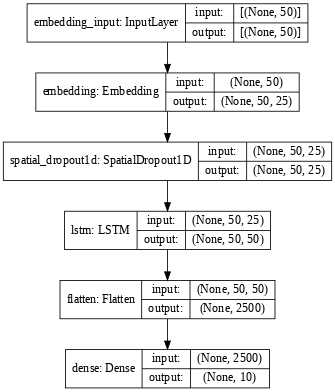

In [ ]:
modelEL=Sequential()
modelEL.add(Embedding(max_words_qty, 25, input_length=xLen))
modelEL.add(SpatialDropout1D(0.2))
modelEL.add(LSTM(50, return_sequences=True))
modelEL.add(Flatten())
modelEL.add(Dense(10, activation='softmax'))

modelEL.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
modelEL.summary()
print()
plot_model(modelEL, dpi=60, show_shapes=True)

In [ ]:
modelEL.fit(x_train, y_train, epochs=20, batch_size=28, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
45/45 [==============================] - 4s 39ms/step - loss: 1.9075 - accuracy: 0.2379 - val_loss: 1.6081 - val_accuracy: 0.2977
Epoch 2/20
45/45 [==============================] - 1s 29ms/step - loss: 1.3410 - accuracy: 0.4604 - val_loss: 1.1196 - val_accuracy: 0.5307
Epoch 3/20
45/45 [==============================] - 1s 27ms/step - loss: 0.8173 - accuracy: 0.7144 - val_loss: 0.7932 - val_accuracy: 0.6893
Epoch 4/20
45/45 [==============================] - 1s 27ms/step - loss: 0.4376 - accuracy: 0.8503 - val_loss: 0.3791 - val_accuracy: 0.8900
Epoch 5/20
45/45 [==============================] - 1s 27ms/step - loss: 0.2233 - accuracy: 0.9296 - val_loss: 0.3820 - val_accuracy: 0.8382
Epoch 6/20
45/45 [==============================] - 1s 27ms/step - loss: 0.1421 - accuracy: 0.9555 - val_loss: 0.2374 - val_accuracy: 0.8997
Epoch 7/20
45/45 [==============================] - 1s 27ms/step - loss: 0.0717 - accuracy: 0.9814 - val_loss: 0.2696 - val_accuracy: 0.9385
Epoch 8/20
45

In [ ]:
recognizeMultiClass (modelEL, x_val, y_val)

For Аппендицит recognized:  100.0 %
For Гастрит recognized:  100.0 %
For Гепатит recognized:  100.0 %
For Дуоденит recognized:  100.0 %
For Колит recognized:  100.0 %
For Панкреатит recognized:  100.0 %
For Холицестит recognized:  100.0 %
For Эзофагит recognized:  100.0 %
For Энтерит recognized:  100.0 %
For Язва recognized:  100.0 %
--------------------
Overall recognized:  100.0 %


**- Embedding + Conv1D**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 25)            50000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 25)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 50)            6300      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                23010     
Total params: 79,310
Trainable params: 79,310
Non-trainable params: 0
_________________________________________________________________



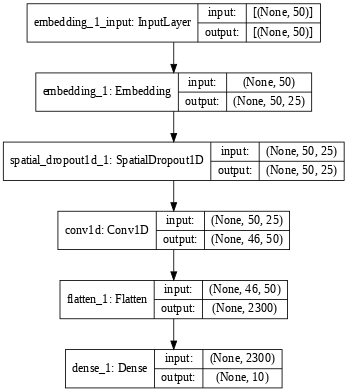

In [ ]:
modelEC=Sequential()
modelEC.add(Embedding(max_words_qty, 25, input_length=xLen))
modelEC.add(SpatialDropout1D(0.2))
modelEC.add(Conv1D(50, kernel_size=5, activation='relu'))
modelEC.add(Flatten())
modelEC.add(Dense(10, activation='softmax'))

modelEC.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelEC.summary()
print()
plot_model(modelEC, dpi=60, show_shapes=True)

In [ ]:
modelEC.fit(x_train, y_train, epochs=20, batch_size=28, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
45/45 [==============================] - 1s 14ms/step - loss: 2.2419 - accuracy: 0.1796 - val_loss: 2.1783 - val_accuracy: 0.1942
Epoch 2/20
45/45 [==============================] - 0s 5ms/step - loss: 1.9315 - accuracy: 0.2492 - val_loss: 1.7456 - val_accuracy: 0.3172
Epoch 3/20
45/45 [==============================] - 0s 5ms/step - loss: 1.3717 - accuracy: 0.4854 - val_loss: 1.1322 - val_accuracy: 0.6311
Epoch 4/20
45/45 [==============================] - 0s 6ms/step - loss: 0.6564 - accuracy: 0.8204 - val_loss: 0.4060 - val_accuracy: 0.9579
Epoch 5/20
45/45 [==============================] - 0s 6ms/step - loss: 0.1835 - accuracy: 0.9943 - val_loss: 0.0946 - val_accuracy: 1.0000
Epoch 6/20
45/45 [==============================] - 0s 5ms/step - loss: 0.0451 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 7/20
45/45 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 8/20
45/45 [=

In [ ]:
recognizeMultiClass (modelEC, x_val, y_val)

For Аппендицит recognized:  100.0 %
For Гастрит recognized:  100.0 %
For Гепатит recognized:  100.0 %
For Дуоденит recognized:  100.0 %
For Колит recognized:  100.0 %
For Панкреатит recognized:  100.0 %
For Холицестит recognized:  100.0 %
For Эзофагит recognized:  100.0 %
For Энтерит recognized:  100.0 %
For Язва recognized:  100.0 %
--------------------
Overall recognized:  100.0 %


**- Embedding + сложная сеть из Dense, LSTM и Conv1D**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 25)            50000     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 20)            3680      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 30)            3030      
_________________________________________________________________
dropout (Dropout)            (None, 46, 30)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1380)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

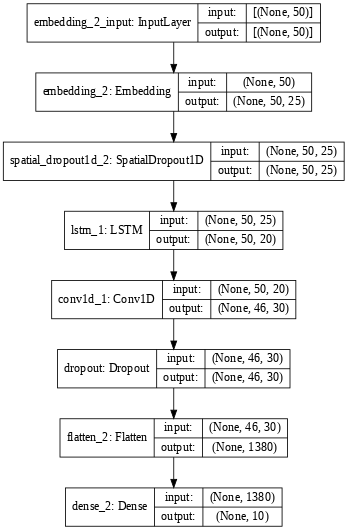

In [ ]:
modelELCD=Sequential()
modelELCD.add(Embedding(max_words_qty, 25, input_length=xLen))
modelELCD.add(SpatialDropout1D(0.2))
modelELCD.add(LSTM(20, return_sequences=True))
modelELCD.add(Conv1D(30, kernel_size=5, activation='relu'))
modelELCD.add(Dropout(0.2))
modelELCD.add(Flatten())
modelELCD.add(Dense(10, activation='softmax'))

modelELCD.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
modelELCD.summary()
print()
plot_model(modelELCD, dpi=60, show_shapes=True)

In [ ]:
modelELCD.fit(x_train, y_train, epochs=20, batch_size=28, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
45/45 [==============================] - 4s 35ms/step - loss: 1.9935 - accuracy: 0.1966 - val_loss: 1.6730 - val_accuracy: 0.2136
Epoch 2/20
45/45 [==============================] - 1s 23ms/step - loss: 1.4198 - accuracy: 0.3447 - val_loss: 1.3434 - val_accuracy: 0.3948
Epoch 3/20
45/45 [==============================] - 1s 24ms/step - loss: 1.0179 - accuracy: 0.5858 - val_loss: 0.8736 - val_accuracy: 0.6861
Epoch 4/20
45/45 [==============================] - 1s 23ms/step - loss: 0.6226 - accuracy: 0.7791 - val_loss: 0.3566 - val_accuracy: 0.8835
Epoch 5/20
45/45 [==============================] - 1s 23ms/step - loss: 0.2951 - accuracy: 0.8981 - val_loss: 0.3517 - val_accuracy: 0.8608
Epoch 6/20
45/45 [==============================] - 1s 23ms/step - loss: 0.1345 - accuracy: 0.9620 - val_loss: 0.6934 - val_accuracy: 0.7799
Epoch 7/20
45/45 [==============================] - 1s 24ms/step - loss: 0.0890 - accuracy: 0.9757 - val_loss: 0.0985 - val_accuracy: 0.9709
Epoch 8/20
45

In [ ]:
recognizeMultiClass (modelELCD, x_val, y_val)

For Аппендицит recognized:  100.0 %
For Гастрит recognized:  100.0 %
For Гепатит recognized:  100.0 %
For Дуоденит recognized:  100.0 %
For Колит recognized:  100.0 %
For Панкреатит recognized:  100.0 %
For Холицестит recognized:  100.0 %
For Эзофагит recognized:  100.0 %
For Энтерит recognized:  100.0 %
For Язва recognized:  100.0 %
--------------------
Overall recognized:  100.0 %
